##  Evalue la qualité de la prédiction d'un modèle / d'une config en regards des métriques obtenues sur différents pas de temps

In [1]:
# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config
from plotting.plotting import error_per_station_calendar_pattern
from examples.train_model_on_k_fold_validation import load_configuration

'pynvml' is not available on this environment.


In [56]:
import pandas as pd
import numpy as np
import math 
from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL



def produce_s_bruit(ts: pd.Series, period: int = 7, take_abs: bool = False) -> pd.Series:
    """
    Décompose la série temporelle `ts` (index datetime) en (trend, season, resid).
    Retourne la composante de bruit (résidu) sous forme d'un pd.Series indexé
    par les mêmes datetimes."""

    result = seasonal_decompose(ts, model='additive', period=period)
    output  = {
        'trend': result.trend.dropna(),
        'seasonal': result.seasonal.dropna(),
        'resid': result.resid.dropna()  # Souvent NaN au debut ou fin 
    }

    # Si on veut juste l'amplitude du Bruit: 
    if take_abs:
        output['resid'] = output['resid'].abs()
    
    return output


def impute_median_by_dow_hour(data,dates_used_in_train,reindex_dates,min_count: int = 10) -> pd.DataFrame:
    """
    Impute les valeurs manquantes de `col` dans `df` en se basant sur :
      1) La médiane par (jour_de_semaine, heure) si le nombre de points dans ce groupe >= min_count
      2) Sinon, la médiane par heure (tous jours confondus) en fallback.

    Hypothèse : df.index est de type DatetimeIndex
    """
    # Get time_serie_for_seasonal_decomposition
    df_base_for_inputation = pd.DataFrame(data = data,index = dates_used_in_train)
    columns = df_base_for_inputation.columns
    df_base_for_inputation['hour'] = df_base_for_inputation.index.hour
    df_base_for_inputation['weekday'] = df_base_for_inputation.index.weekday


    group_dow_hour = df_base_for_inputation.groupby(['hour', 'weekday'])
    median_dow_hour = group_dow_hour.transform('median')
    count_dow_hour = group_dow_hour.transform('count')

    # Median by (hour) if not enough tuple (weekday,hour)
    group_hour = df_base_for_inputation.groupby('hour')
    median_hour = group_hour.transform('median').drop(columns=['weekday'])

    impute_val = np.where(count_dow_hour < min_count, median_hour, median_dow_hour)

    values_to_be_imputed = pd.DataFrame(impute_val,index = df_base_for_inputation.index,columns = median_dow_hour.columns)
    values_to_be_imputed['hour'] = values_to_be_imputed.index.hour
    values_to_be_imputed['weekday'] = values_to_be_imputed.index.weekday


    # Re-index df:
    time_series_for_seasonal_decomposition = df_base_for_inputation.reindex(reindex_dates) 
    time_series_for_seasonal_decomposition['hour'] = time_series_for_seasonal_decomposition.index.hour
    time_series_for_seasonal_decomposition['weekday'] = time_series_for_seasonal_decomposition.index.weekday

    # Input Missing Data: 
    data_to_input = time_series_for_seasonal_decomposition[time_series_for_seasonal_decomposition.isna().sum(axis=1) > 0]
    L_input_col = [values_to_be_imputed.pivot_table(index = 'hour',columns = 'weekday', values = col) for col in columns]
    data_to_input = data_to_input.apply(lambda row: replace_values(row,L_input_col,columns),axis = 1)
    time_series_for_seasonal_decomposition =time_series_for_seasonal_decomposition.fillna(data_to_input).drop(columns = ['hour','weekday'])
    return time_series_for_seasonal_decomposition



def replace_values_by_colunm(row,col,values_to_be_imputed):
    if math.isnan(row[col]):
        row[col] = values_to_be_imputed.at[int(row['hour']),int(row['weekday'])]
    return row 


def replace_values(row,L_input_col,columns):
    for k,col in enumerate(columns):
        row[col] = L_input_col[col].at[int(row['hour']),int(row['weekday'])]
    return row 

<Axes: >

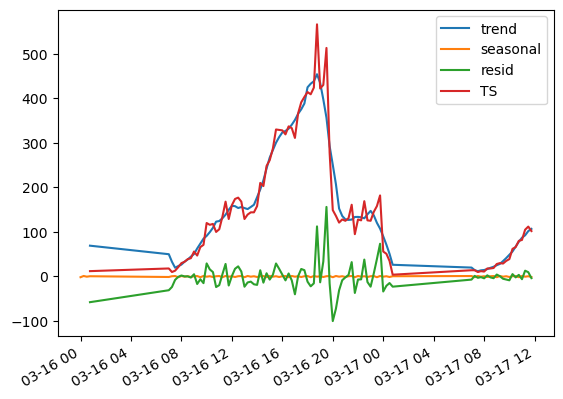

In [10]:
import pandas as pd 
from constants.paths import USELESS_DATES


df_verif_train = ds.tensor_limits_keeper.df_verif_train
dates_used_in_train = pd.Series(pd.concat([df_verif_train[c] for c in df_verif_train.columns]).unique()).sort_values() # Concat forbidden indexes within each columns

# Get corresponding indices:
df_verif_train_ind = pd.DataFrame()
for c in df_verif_train.columns:
    df_verif_train_ind[c] = df_verif_train.index + int(c.split('t')[-1])
ind_used_in_train = pd.Series(pd.concat([df_verif_train_ind[c] for c in df_verif_train_ind.columns]).unique()).sort_values()

# Reindex 
reindex_dates = pd.date_range(dates_used_in_train.min(),dates_used_in_train.max(),freq=f"{1/ds.time_step_per_hour}h")


forbidden_hour = USELESS_DATES['hour']
forbidden_weekday = USELESS_DATES['weekday']
reindex_dates = reindex_dates[~reindex_dates.hour.isin(forbidden_hour)]
min_count = 10

time_series_for_seasonal_decomposition = impute_median_by_dow_hour(ds.raw_values[ind_used_in_train].numpy(),dates_used_in_train,reindex_dates,min_count)

period = 7 #int(7 * 24 * ds.time_step_per_hour)
noise = {}
for col in time_series_for_seasonal_decomposition.columns:
    noise_from_decomposition = produce_s_bruit(time_series_for_seasonal_decomposition[col], period=period,take_abs= False)
    noise[col] = noise_from_decomposition

pd.DataFrame({'trend': noise_from_decomposition['trend'],
              'seasonal': noise_from_decomposition['seasonal'],
              'resid': noise_from_decomposition['resid'],
              'TS': noise_from_decomposition['trend']+noise_from_decomposition['seasonal']+noise_from_decomposition['resid']}
              ).iloc[:96].plot()

In [78]:
noise_from_decomposition['seasonal']

,seasonal_504,seasonal_504
2019-03-16 00:00:00,-47.444438,0.001100
2019-03-16 00:15:00,-39.249380,-0.110302
2019-03-16 00:30:00,-62.878713,0.198569
2019-03-16 00:45:00,-80.555349,0.400410
2019-03-16 07:00:00,-76.203587,0.504685
...,...,...
2019-05-01 08:15:00,-19.575815,-2.445034
2019-05-01 08:30:00,-25.352263,-2.379663
2019-05-01 08:45:00,-31.674864,-2.386000
2019-05-01 09:00:00,-46.386196,-1.839744


In [79]:
result.seasonal.columns

Index(['seasonal_72', 'seasonal_504'], dtype='object')

<Axes: >

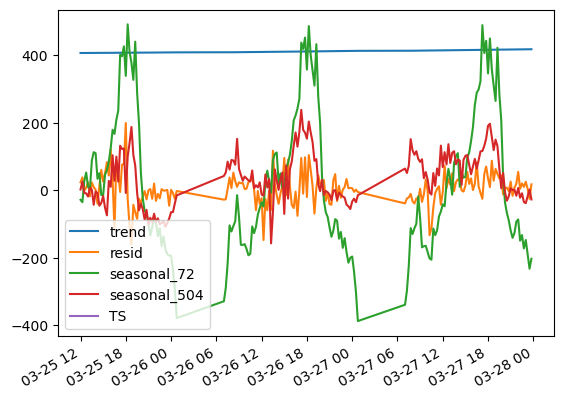

In [82]:
def produce_s_bruit(ts: pd.Series, period: int = 7, take_abs: bool = False) -> pd.Series:

    if False:
        result = seasonal_decompose(ts, model='additive', period=period)
    if False : 
        stl = STL(ts, period=period)
        result = stl.fit()
    if True:
        mstl = MSTL(ts, periods=period)
        result = mstl.fit()
    output  = {
        'trend': result.trend.dropna(),
        'seasonal': result.seasonal.dropna(),
        'resid': result.resid.dropna()  # Souvent NaN au debut ou fin 
    }

    # Si on veut juste l'amplitude du Bruit: 
    if take_abs:
        output['resid'] = output['resid'].abs()
    
    return output


period = [4*7*(24-len(USELESS_DATES['hour'])),4*(24-len(USELESS_DATES['hour']))]
# daily : 4*7*(24-len(USELESS_DATES['hour']))  
# weekly : 4*7*(24-len(USELESS_DATES['hour']))  

noise = {}
for col in time_series_for_seasonal_decomposition.columns: #[:2]:
    noise_from_decomposition = produce_s_bruit(time_series_for_seasonal_decomposition[col], period=period,take_abs= False)
    noise[col] = noise_from_decomposition


# Plotting on one specific column: 
df_decomposition = pd.DataFrame({'trend': noise_from_decomposition['trend'],
                                 'resid': noise_from_decomposition['resid']})

if type(noise_from_decomposition['seasonal']) == pd.DataFrame:
    for col_i in noise_from_decomposition['seasonal'].columns:
        df_decomposition[col_i] = noise_from_decomposition['seasonal'][col_i]
else:
    df_decomposition['seasonal'] = noise_from_decomposition['seasonal']

df_decomposition['TS'] = df_decomposition.sum(axis=1)
df_decomposition.iloc[96*7:96*9].plot()

In [86]:
df_decomposition.iloc[:,:-1]

2019-03-16 00:00:00    3.960000e+02
2019-03-16 00:15:00    2.980000e+02
2019-03-16 00:30:00    2.580000e+02
2019-03-16 00:45:00    4.400000e+01
2019-03-16 07:00:00    3.200000e+01
                           ...     
2019-05-01 08:15:00   -2.842171e-14
2019-05-01 08:30:00    8.526513e-14
2019-05-01 08:45:00    0.000000e+00
2019-05-01 09:00:00   -8.526513e-14
2019-05-01 09:15:00    2.842171e-14
Length: 3326, dtype: float64

In [2]:
import torch 
from examples.train_and_visu_non_recurrent import get_ds

trial_id ='subway_in_STGCN_MSELoss_2025_01_06_08_00_94523'
args,_ = load_configuration(trial_id,load_config=True,epochs=None)


station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
training_mode_to_visualise = ['test']#,'valid','train']
modification ={'keep_best_weights':True,
                'epochs':1,
                'validation_split_method' : 'forward_chaining_cv',
                'min_fold_size_proportion': 0.75,
                'train_prop':0.6,
                'valid_prop':0.2,
                'test_prop':0.2,
                'data_augmentation':True,  #False
                'DA_method':'interpolation',
                'DA_moment_to_focus' :[{'hours':[0,23],'weekdays':[1,3]}], # None
                }
ds,args_modif,trial_id,save_folder,df_loss = get_ds(args.model_name,args.dataset_names,args.dataset_for_coverage,
                                              modification=modification,args_init=args,fold_to_evaluate=[args.K_fold-1])

U_train_copy = ds.U_train.clone()
Utarget_train_copy = ds.Utarget_train.clone()
dates_train = ds.tensor_limits_keeper.df_verif_train.iloc[:,-1].reset_index(drop=True)
p_inject = 1
alpha = 1

n, N, L = U_train_copy.shape

# mask_inject : bool de taille [n, N].  On choisit aléatoirement p_inject% des sequences (t, i) à bruiter
mask_inject = torch.rand(n, N) < p_inject
mask_seq_3d = mask_inject.unsqueeze(-1).expand(-1, -1, L)  # Repeat on the dimension L

# Get Amplitude of noises for each timesteps:
amp_series = s_bruit.reindex(dates_train, fill_value=0)

# Reshape
amp_values = amp_series.to_numpy().reshape(n, N, L)
amp_bruit_tensor = torch.from_numpy(amp_values).float()

# Gaussian Noise
noise = torch.randn(n, N, L)  # Gaussian Noise

# Scaled with computed amplitude and an 'alpha' factor: 
scaled_noise = noise * alpha * amp_bruit_tensor  # shape [n, N, L]

# Noise injection on some masked values 
U_train_copy += scaled_noise * mask_seq_3d


>>>> Load best CONFIG

Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

92 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2913 940 940

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified

NameError: name 's_bruit' is not defined

## Load Config from HP tuning
```trial_id = 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523'
# "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"
# "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963"
# 'subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_05_04_80480'
# "subway_in_STGCN_MSELoss_2025_01_06_08_00_94523"
args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

In [ ]:
for trial_id in ['subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963',
                 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 #"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

## Sans Week-ends

Trial id:  subway_in_STGCN_MSELoss_2025_01_06_08_00_94523

>>>> Load best CONFIG



Init Dataset:  torch.Size([7392, 40])
Number of Nan Value:  tensor(0)
Total Number of Elements:  295680 

92 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2913 940 940

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing

 ===== ERROR ==== 
Try with torch >= 2.0.0 (works with 2.0.1) to allow 'prefetch_factor' 
ValueError: prefetch_factor option could only be specified in multiprocessing.let

Loading BokehJS ...

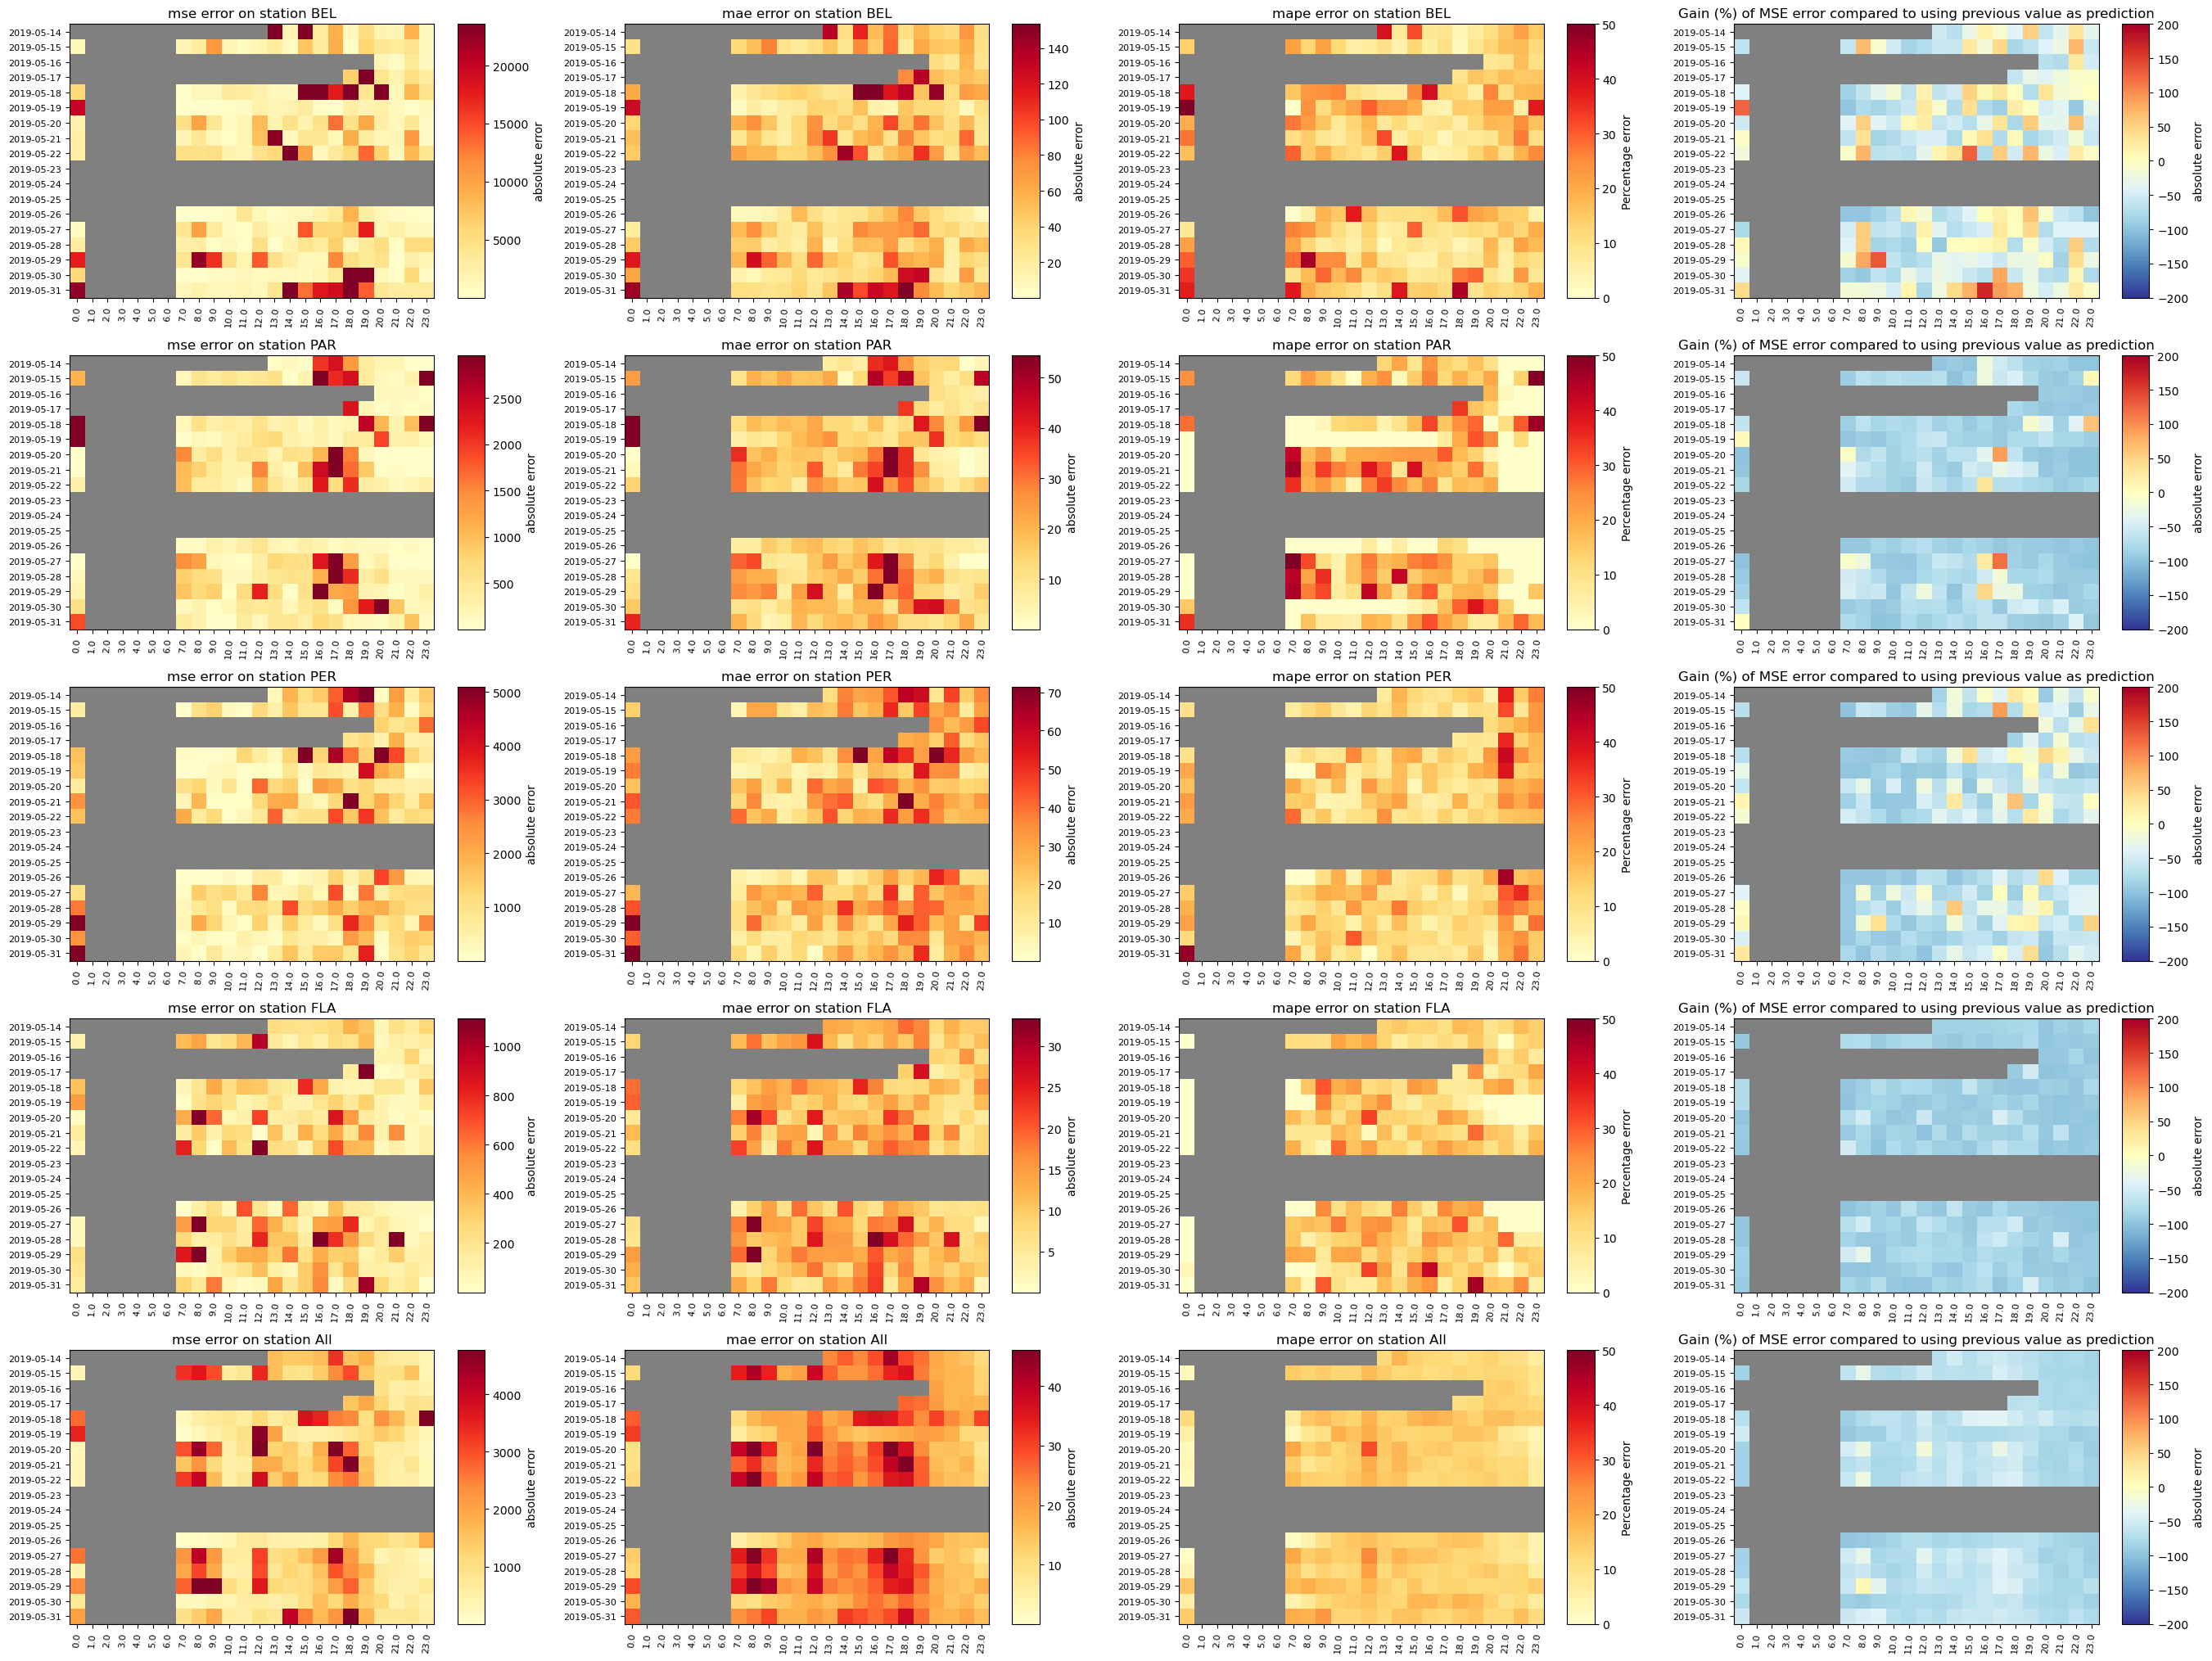

In [2]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 ]:
    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':10,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True,  #False
                   'DA_method':'interpolation',
                   'DA_moment_to_focus' :[{'hours':[0,23],'weekdays':[1,3]}], # None
                   #'W' : args_best_model.Weeks,
                   #'D' : args_best_model.Days,
                   #'historical_length':args_best_model.H
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        day_date = getattr(ds_no_shuffle.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].dt.date.unique()
        nb_days = (day_date.max()-day_date.min()).days
        y_size = 1.2*nb_days #4,15
        x_size = 6.8*len(station)
        fig,axes = error_per_station_calendar_pattern(trainer,ds_no_shuffle,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (x_size,y_size),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

## Avec Week-ends

In [ ]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 ]:
    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','GER']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid','train']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        
        # Set figsize:
        day_date = getattr(ds_no_shuffle.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1].dt.date.unique()
        nb_days = (day_date.max()-day_date.min()).days
        y_size = 1.2*nb_days #4,15
        x_size = 6.8*len(station)
        fig,axes = error_per_station_calendar_pattern(trainer,ds_no_shuffle,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (x_size,y_size),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

In [ ]:
for trial_id in ['subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963',
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test']#,'valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100,
                   'validation_split_method' : 'forward_chaining_cv',
                   'min_fold_size_proportion': 0.75,
                   'train_prop':0.6,
                   'valid_prop':0.2,
                   'test_prop':0.2,
                   'data_augmentation':True
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [args_best_model.K_fold-1] #[0]
                                                    
                                                    )

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 40  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station,
                                                    index_matshow = 'date',
                                                    columns_matshow = 'hour')
    break

In [ ]:
for trial_id in ['subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192',
                 'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 #"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
                 ]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True,
                   'epochs':100
                   }
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])

    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)
    break


In [ ]:
ds.tensor_limits_keeper.df_verif_train.iloc[t+]

In [ ]:
for training_mode in ['train']:
    min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
    limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
    fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                freq='1h',
                                                min_flow=min_flow,
                                                figsize = (30,5*len(station)),
                                                limit_percentage_error = limit_percentage_error,
                                                stations = station)

In [56]:
from plotting.plotting import get_y_size_from_temporal_agg,temporal_aggregation_of_attn_weight
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

def plot_attn_weight(trainer,nb_calendar_data,ds,training_mode = None,temporal_agg = None,save=None,stations= None):

    # Load Inputs : 
    X,Y,X_c,nb_contextual = trainer.load_all_inputs_from_training_mode(training_mode)
    

    X = X.to(trainer.args.device)
    Y = Y.to(trainer.args.device)
    X_c = [x_c.to(trainer.args.device)for x_c in X_c]
    # Init:
    num_heads = trainer.args.args_vision.num_heads
    spatial_units = list(ds.spatial_unit)
    if stations is not None :
        nb_stations_to_plot = len(stations)*num_heads 
    else :
        stations = list(ds.spatial_unit)
        nb_stations_to_plot = Y.size(1)*num_heads 
    num_cols = 4
    

    nb_rows = (nb_stations_to_plot + num_cols - 1) // num_cols  
    y_size = get_y_size_from_temporal_agg(temporal_agg)
    #plt.figure(figsize=(5*num_cols,y_size))  
    plt.figure(figsize=(5*num_cols*max(1,nb_stations_to_plot//15),int(y_size*max(1,nb_stations_to_plot//num_cols))))


    for station_i in range(nb_stations_to_plot//num_heads):

        station_ind  = spatial_units.index(stations[station_i])

        enhanced_x,attn_weights = trainer.model.netmob_vision.model[station_ind](X[:,station_ind,:],X_c[station_ind+nb_calendar_data],x_known = None)
        nb_contextuals = attn_weights.size(-1)

        mh_attn_weights_reshaped = attn_weights.squeeze().detach().cpu().numpy()  # Shape [B,num_heads,P]
        for head_i in range(num_heads):
            if num_heads == 1:
                attn_weights_reshaped = mh_attn_weights_reshaped
            else:
                attn_weights_reshaped = mh_attn_weights_reshaped[:,head_i,:]
            

            # Temporal Aggregation of attn weight:
            attn_weights_reshaped,str_dates = temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg)
            ax = plt.subplot(nb_rows, num_cols, (station_i*num_heads)+head_i + 1)  # Créer un subplot

            vmin,vmax = 0,min(1,1/(nb_contextuals/3)) 
            im = ax.imshow(attn_weights_reshaped, cmap='hot', aspect='auto',vmin=vmin,vmax=vmax)
            plt.colorbar(im,label='Attention Weight',shrink = 0.25)
            
            if temporal_agg is None:
                plt.title(f'Attention Weight\nof station {station_ind} ({spatial_units[station_ind]}) head {head_i} \nfor each sample of the batch')
                plt.ylabel('Samples')
            else:
                plt.title(f'Mean Attention Weight\nof station {station_i}({spatial_units[station_ind]}) head {head_i} \nby calendar class') 
                plt.ylabel('Calendar class')
            plt.xlabel('Contextual time-series')


            num_samples, nb_contextual_on_plot_i = attn_weights_reshaped.shape
            plt.xticks(ticks=np.arange(nb_contextual_on_plot_i), labels=[f'Unit {i}' for i in range(nb_contextual_on_plot_i)], rotation=45)
            plt.yticks(ticks=np.arange(num_samples), labels=str_dates)

        plt.tight_layout()

    if save is not None:
        plt.savefig(f'{save}.pdf',format = 'pdf',bbox_inches='tight')
    plt.show()

def temporal_aggregation_of_attn_weight(attn_weights_reshaped,ds,training_mode,temporal_agg):
    ''' 
    Return the temporal aggregation of attn weights to visualise them 

    args:
    ------
    temporal_agg : choices ['hour','weekday','weekday_hour','weekday_hour_minutes']
    '''

    if temporal_agg is not None:
        index_df = getattr(ds.tensor_limits_keeper,f"df_verif_{training_mode}").iloc[:,-1]
        df = pd.DataFrame(attn_weights_reshaped,index = index_df) #,columns = ds.spatial_unit)
        weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


        if temporal_agg == 'hour':
            df_agg = df.groupby([df.index.hour]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{x:02d}"))

        elif temporal_agg == 'weekday':
            df_agg = df.groupby([df.index.weekday]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: weekdays[x]))

        elif temporal_agg == 'weekday_hour':
            df_agg = df.groupby([df.index.weekday,df.index.hour]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{weekdays[x[0]]} {x[1]:02d}"))

        elif temporal_agg == 'weekday_hour_minute':
            df_agg = df.groupby([df.index.weekday,df.index.hour,df.index.minute]).agg('mean')
            str_dates = list(df_agg.index.map(lambda x: f"{weekdays[x[0]]} {x[1]:02d}:{x[2]:02d}"))
        else:
            raise NotImplementedError(f'Temporal aggregation {temporal_agg} has not been implemented')
        attn_weights_reshaped = df_agg.values  
    else:
        str_dates = list(df.index.strftime('%Y-%m-%d %H:%M'))

    return attn_weights_reshaped,str_dates


In [ ]:
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)

training_mode = 'test'
temporal_agg = 'weekday_hour' # 'hour' # 'weekday' # 'weekday_hour'
save = 'attn_weight'

plot_attn_weight(trainer,nb_calendar_data,ds= ds,training_mode = training_mode,temporal_agg = temporal_agg,save=save,stations= ['CUS','PER','PAR'])

In [ ]:
trainer.model.netmob_vision.model[0].attention.W_v

In [ ]:
from plotting.plotting import plot_attn_weight
from constants.paths import CALENDAR_TYPE
nb_calendar_data = len(CALENDAR_TYPE)

training_mode = 'test'
temporal_agg = 'weekday_hour' # 'hour' # 'weekday' # 'weekday_hour'
save = 'attn_weight'
plot_attn_weight(trainer,nb_calendar_data,ds,training_mode,temporal_agg,save)

### Evaluate config :

In [ ]:
for trial_id in ['subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
                 "subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_06_02_04_17963",
                 "subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_07_23_12_41192"]:

    print('Trial id: ',trial_id)
    args_best_model,_ = load_configuration(trial_id,load_config=True,epochs=None)

    station = ['BEL','PAR','PER','FLA']   # 'BON'  #'GER'
    training_mode_to_visualise = ['test','valid'] # ['test','valid','train']
    modification ={'keep_best_weights':True}
    #modification = {'epochs':1}

    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                    station = station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise,
                                                    args_init =args_best_model,
                                                    fold_to_evaluate = [0])


    # Init
    for training_mode in training_mode_to_visualise:
        min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
        limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
        fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                    freq='1h',
                                                    min_flow=min_flow,
                                                    figsize = (30,5*len(station)),
                                                    limit_percentage_error = limit_percentage_error,
                                                    stations = station)

## Load config defined 'by hand' :

In [ ]:
dataset_names = ["subway_in"] # ["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGCN'

station = ['BEL','PAR','AMP','FLA']   # 'BON'  #'GER'
# ...

modification = {'epochs' : 1, #100
                'lr':4e-4}
training_mode_to_visualise = ['test']

(trainer,ds,ds_no_shuffle,args) = evaluate_config(model_name,dataset_names,dataset_for_coverage,
                                                   station = station,modification=modification,training_mode_to_visualise=training_mode_to_visualise)